In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atharvaingle/crop-recommendation-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/james/.cache/kagglehub/datasets/atharvaingle/crop-recommendation-dataset/versions/1


In [18]:
import pandas

# Use columns 0 up to and including 6 (Nitrogen to Rainfall)
crop_data = pandas.read_csv("../data/Crop_recommendation.csv", header = 0, usecols = range(8))

# Get different selections with and without label, and also one 
# that is just y
crop_data_no_classes = crop_data.iloc[:, 0:7]
crop_data_with_classes = crop_data.iloc[:, :]
crop_data_classes = crop_data.iloc[:,7]

print(crop_data_no_classes)

        N   P   K  temperature   humidity        ph    rainfall
0      90  42  43    20.879744  82.002744  6.502985  202.935536
1      85  58  41    21.770462  80.319644  7.038096  226.655537
2      60  55  44    23.004459  82.320763  7.840207  263.964248
3      74  35  40    26.491096  80.158363  6.980401  242.864034
4      78  42  42    20.130175  81.604873  7.628473  262.717340
...   ...  ..  ..          ...        ...       ...         ...
2195  107  34  32    26.774637  66.413269  6.780064  177.774507
2196   99  15  27    27.417112  56.636362  6.086922  127.924610
2197  118  33  30    24.131797  67.225123  6.362608  173.322839
2198  117  32  34    26.272418  52.127394  6.758793  127.175293
2199  104  18  30    23.603016  60.396475  6.779833  140.937041

[2200 rows x 7 columns]


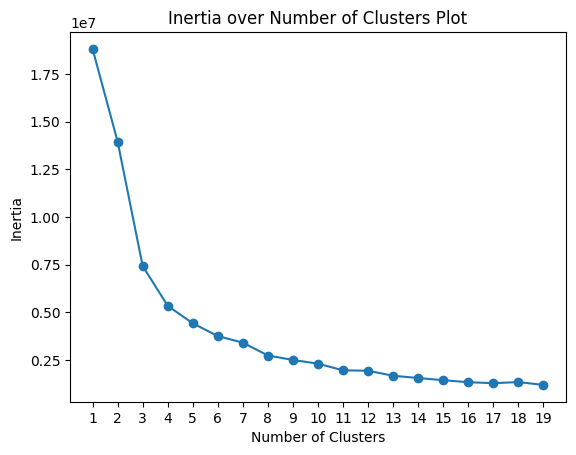

In [21]:
# Convert crop data to matrix
matrix = crop_data_no_classes.values
matrix_classes = crop_data_classes.values

from sklearn.cluster import *
import matplotlib.pyplot as plt

inertia = []

for i in range(1,20):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(matrix)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,20), inertia, marker = 'o')
plt.xticks(range(1,20))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Inertia over Number of Clusters Plot")
plt.show()

### *We have about 5 different clusters here, using the elbow method.*

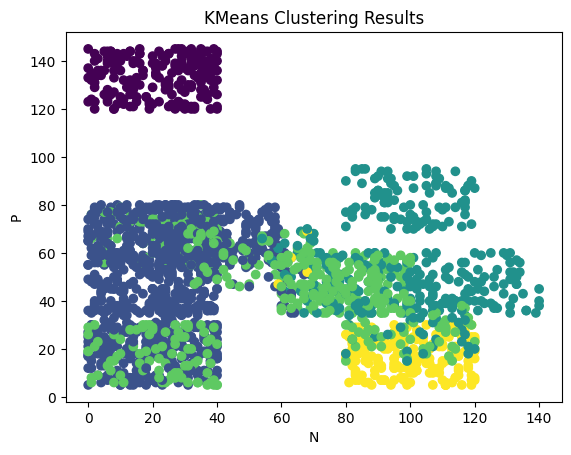

In [67]:
kmeans = KMeans(n_clusters = 5, random_state=0)
kmeans.fit(matrix)

kmeans_labels = kmeans.labels_
# for label in labels:
#     print(label)


crop_data_with_labels = crop_data
crop_data_with_labels['kmeans clusters'] = kmeans_labels
#print(crop_data_with_labels)

# Now, we visualize this new labeled data

x_col = 0
y_col = 1

plt.scatter(matrix[:, x_col], matrix[:, y_col], c=kmeans_labels, cmap='viridis')
plt.xlabel(f'{crop_data.columns[x_col]}')
plt.ylabel(f'{crop_data.columns[y_col]}')
plt.title(f'KMeans Clustering Results')
plt.show()

In [23]:
# Step 1: Compute k-distances for DBScan
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mean_scores = []

neighbor_values = range(2,21)

#Determining optimal k value for knn, from 2 to 21
for sample_num in range(2,21):
    knn = KNeighborsClassifier(n_neighbors=sample_num)

    # get the cv score of this particular neighbor number selection
    scores = cross_val_score(knn, matrix, matrix_classes, cv=kf, scoring='accuracy')
    mean_scores.append(np.mean(scores))

#Get the best mean value from the best-performing 
#selection of neighbor values
best_mean = neighbor_values[np.argmax(mean_scores)]
best_score = max(mean_scores)

print(f"Best num neighbors for KNN : {best_mean} has cv score {best_score}")

Best num neighbors for KNN : 3 has cv score 0.9813636363636362


### *Ideal number of neighbors for KNN is around 3*

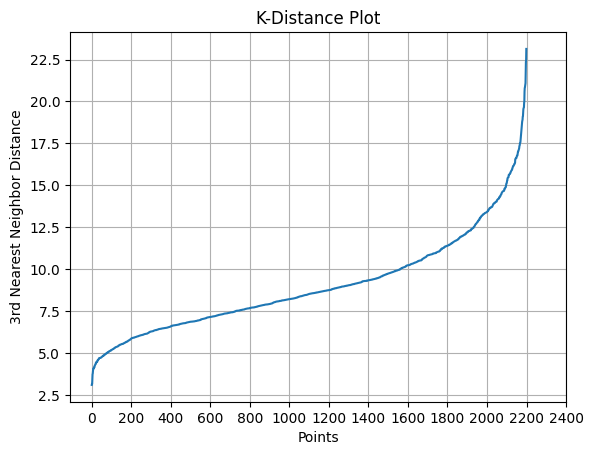

In [34]:
# We will now determine the ideal value of epsilon for DBScan, using the
# ideal value we found for knn

# Create knn classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit this knn classifier onto the matrix
neighbors_fit = knn.fit(matrix, matrix_classes)

# Get all distances from each point in the data
# to kth (in this case, k-1) neighbor
distances, indices = neighbors_fit.kneighbors(matrix, 3)

# All rows for 3rd nearest neighbor
distances = np.sort(distances[:, 2], axis = 0)

plt.plot(distances)
plt.xticks(range(0,2500,200))
plt.xlabel('Points')
plt.ylabel(f'3rd Nearest Neighbor Distance')
plt.title("K-Distance Plot")
plt.grid(True)
plt.show()

### *Using the elbow method, epsilon (the point at which distance begins to dramatically rise)*
### *is about 11.25*

Text(0, 0.5, 'N')

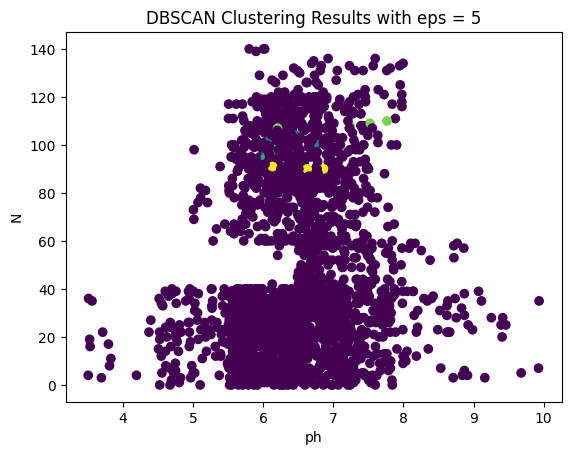

In [94]:
# We will now perform DBScan with the epsilon we discovered above,
# and the ideal KNN value of 3.

dbscan = DBSCAN(eps = 4, min_samples = 3)
dbscan_labels = dbscan.fit_predict(X = matrix)

crop_data_with_labels["dbscan clusters"] = dbscan_labels

x_col = 5
y_col = 0

plt.scatter(matrix[:,x_col], matrix[:,y_col], c = dbscan_labels, cmap = 'viridis')
plt.title("DBSCAN Clustering Results with eps = 5")
plt.xlabel(crop_data.columns[x_col])
plt.ylabel(crop_data.columns[y_col])

In [95]:
# Finally, we add the classes back on, so now we can graph coloring labels
# from kmeans, dbscan, and the classes

crop_data_with_labels["class"] = crop_data_classes

In [96]:
print(max(crop_data_with_labels.loc[:,"dbscan clusters"]))
print(crop_data_with_labels)
crop_data_with_labels.to_csv("../data/output.csv")

4
        N   P   K  ...  kmeans clusters  dbscan clusters   class
0      90  42  43  ...                3               -1    rice
1      85  58  41  ...                3               -1    rice
2      60  55  44  ...                3               -1    rice
3      74  35  40  ...                3               -1    rice
4      78  42  42  ...                3               -1    rice
...   ...  ..  ..  ...              ...              ...     ...
2195  107  34  32  ...                3               -1  coffee
2196   99  15  27  ...                2               -1  coffee
2197  118  33  30  ...                3               -1  coffee
2198  117  32  34  ...                2               -1  coffee
2199  104  18  30  ...                2               -1  coffee

[2200 rows x 10 columns]


In [102]:
# We need to group by each label, and then see what classes compose each
# label

classes_by_label = crop_data_with_labels.groupby(['kmeans clusters', 'class']).size().reset_index(name = 'number of samples')

print(classes_by_label)

    kmeans clusters        class  number of samples
0                 0        apple                100
1                 0       grapes                100
2                 1    blackgram                100
3                 1     chickpea                100
4                 1      coconut                 10
5                 1  kidneybeans                100
6                 1       lentil                100
7                 1        maize                 19
8                 1        mango                100
9                 1    mothbeans                100
10                1     mungbean                100
11                1       orange                100
12                1       papaya                 29
13                1   pigeonpeas                 47
14                1  pomegranate                100
15                2       banana                100
16                2       coffee                 46
17                2       cotton                100
18          

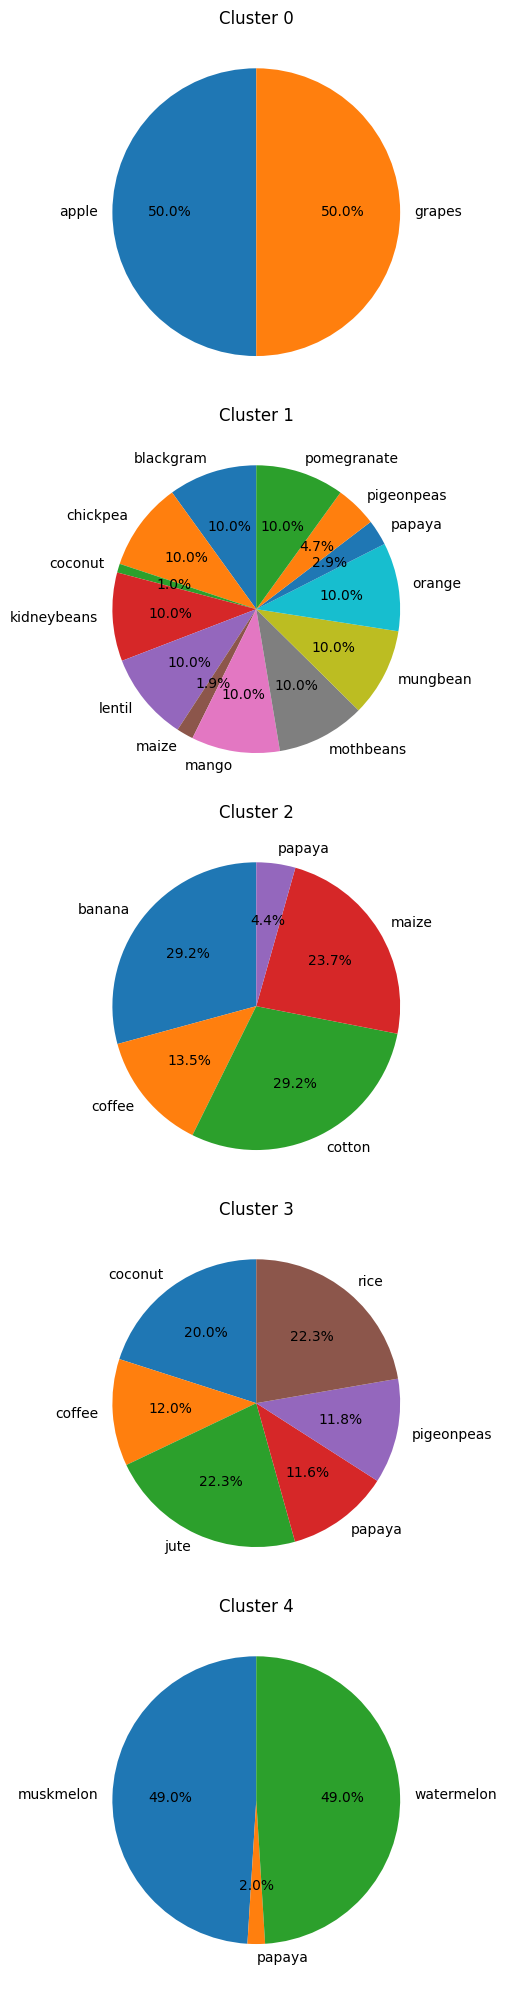

In [108]:
# Let's get the fractions of each class that compose each label and graph
# them.

grouped_clusters = classes_by_label.groupby(["kmeans clusters", "class"])["number of samples"].sum().reset_index()

total_samples_per_cluster = grouped_clusters.groupby('kmeans clusters')['number of samples'].transform('sum')

# The fraction here is the total fraction of each class which composes each
# cluster / label
grouped_clusters["fraction"] = grouped_clusters["number of samples"] / total_samples_per_cluster

# print(grouped_clusters)

fig, axes = plt.subplots(len(grouped_clusters['kmeans clusters'].unique()), 1, figsize=(40, 20))

for i, cluster in enumerate(grouped_clusters['kmeans clusters'].unique()):
    # Get the data for the current cluster
    cluster_data = grouped_clusters[grouped_clusters['kmeans clusters'] == cluster]
    
    # Plot pie chart
    axes[i].pie(cluster_data['fraction'], labels=cluster_data['class'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Cluster {cluster}')
    
plt.tight_layout()
plt.show()